Oleksandr Korotetskyi (korotole)

Video Resolution Upscaling Using Neural Networks

Experimental video resolution upscalling

In [ ]:
from google.colab import drive

# mount google disk storage
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install requirements
! cd drive/'My Drive/MVI' && pip install --user -r requirements.txt && pip install isr PyJWT==1.7.1 h5py==2.10.0 --force-reinstall

  Using cached absl_py-0.9.0-py3-none-any.whl
  Using cached numpy-1.16.0-cp37-cp37m-manylinux1_x86_64.whl (17.3 MB)
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Using cached Werkzeug-0.15.0-py2.py3-none-any.whl (328 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
     |████████████████████████████████| 58 kB 5.4 MB/s 
     |████████████████████████████████| 127 kB 34.0 MB/s 
  Using cached wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires numpy>=1.17, but you have numpy 1.16.0 which is incompatible.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
pyerfa 2.0.0.1 requires numpy>=1.17, but you have numpy

In [ ]:
# import scope
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

Display folder's content with input **HD** videos

For our expirement will be enough to take one of them.. for example: **video_short_5_sec.mp4**

In [ ]:
! ls -l drive/'My Drive'/MVI/data/inputs

total 22999
-rw------- 1 root root  1709643 Dec 31 19:40 LArrivee_dun_train2.mp4
-rw------- 1 root root   213674 Dec 31 19:40 LArrivee_dun_train.mp4
-rw------- 1 root root  4143852 Dec  3 22:38 old1-copy.webm
-rw------- 1 root root  4143852 Dec  3 14:14 old1.webm
-rw------- 1 root root 13337787 Dec  3 14:11 old2.webm


Next we will use predefined script for video slicing to frames.

At first, lets print it's help

In [ ]:
! python3 drive/'My Drive'/MVI/video_splitter.py --help

Usage: video_splitter.py [OPTIONS]

  Split input video to frames

Options:
  -i, --input_path PATH   Path to input video
                          [required]

  -o, --output_path PATH  Path where video frames
                          will be saved.

  -c, --count PATH        Count of result frames:
                          this param allows to
                          limit count of result
                          frames

  --help                  Show this message and
                          exit.


Let's split video to frames:

* input_video_path: **./drive/My Drive/MVI/data/inputs/LArrivee_dun_train.mp4**
* output_directory_path: **./drive/My Drive/MVI/data/video_frames/**
* count_of_output_frames/images: **5**

In [ ]:
! python3 drive/'My Drive'/MVI/video_splitter.py -i drive/MyDrive/MVI/data/inputs/LArrivee_dun_train.mp4 -o drive/MyDrive/MVI/data/video_frames/ -c 5

Start reading input videos..
Start slicing video to frames to path drive/MyDrive/MVI/data/video_frames/
100% 5/5 [00:00<00:00, 110.48it/s]
Successfully obtain 5 frames from video.


Let's display result of splitting: 5 frames

In [ ]:
! ls -l drive/'My Drive'/MVI/data/video_frames/

total 156
-rw------- 1 root root 31837 Dec 31 21:30 LArrivee_dun_train_frame1.jpg
-rw------- 1 root root 31744 Dec 31 21:30 LArrivee_dun_train_frame2.jpg
-rw------- 1 root root 31572 Dec 31 21:30 LArrivee_dun_train_frame3.jpg
-rw------- 1 root root 31526 Dec 31 21:30 LArrivee_dun_train_frame4.jpg
-rw------- 1 root root 31424 Dec 31 21:30 LArrivee_dun_train_frame5.jpg


Than import predefined model from **model.py** and ImageWrapper from **image_wrapper.py**

In [ ]:
import sys
sys.path.append('drive/MyDrive/MVI')
sys.path.append('drive/MyDrive/MVI/src')

from src.model import Model
from src.image_wrapper import ImageWrapper

Load predefined

In [ ]:
model = Model.load_model()

Staring initialization..
Done.


In [ ]:
# read prepared frames from dir and wrap them to ImageWrapper class

path_dir_with_frames = 'drive/MyDrive/MVI/data/video_frames/'
# define crop (can be random.. to your preferences)
crop = [780, 250, 1060, 710]

# obtain images names from di
frames_in_dir = os.listdir(path_dir_with_frames)

wrapped_frames = []
for image_name in frames_in_dir:
  # orig image/frame
  print(f"Obtaining image from path {path_dir_with_frames + image_name}")
  img = Image.open(path_dir_with_frames + image_name)
  # if imgs not full hd, this will upscale them 
  img = img.resize((1920,1080), Image.BILINEAR)
  ground_truth_wrapper = ImageWrapper(image_name, img, crop)

  wrapped_frames.append(ground_truth_wrapper)

Obtaining image from path drive/MyDrive/MVI/data/video_frames/LArrivee_dun_train_frame1.jpg
Obtaining image from path drive/MyDrive/MVI/data/video_frames/LArrivee_dun_train_frame3.jpg
Obtaining image from path drive/MyDrive/MVI/data/video_frames/LArrivee_dun_train_frame2.jpg
Obtaining image from path drive/MyDrive/MVI/data/video_frames/LArrivee_dun_train_frame4.jpg
Obtaining image from path drive/MyDrive/MVI/data/video_frames/LArrivee_dun_train_frame5.jpg


In [ ]:
# constants scope
original_size = (1920,1080) # full HD size
crop = [780, 250, 1060, 710]
path_to_save_modified_frames = 'drive/MyDrive/MVI/data/midified_frames/'

"""Save result of experiment/image to output path"""
def save_image(image_obj, image_full_path_to_save: str):
  if not os.path.exists(image_full_path_to_save):
    print(f"Saving image to path {image_full_path_to_save}")
    cv2.imwrite(image_full_path_to_save + ".jpg", np.array(image_obj))  # save frame as JPG file
    # image_obj.save(image_full_path_to_save, "JPG")
    
"""Plotter for a single image"""
def image_plotter(axs):
    axs = axs.flat
    def plot_image(X, title, **kwargs):
        ax = next(axs) 
        ax.imshow(X,**kwargs)
        ax.set_title(title)
    return plot_image

"""Function providing: donwscaling, upscaling, save to output and plot result"""
def plot_and_save_upscaling_results(image, scale_factors, save_output=True): 
    fig = plt.Figure()
    DPI = fig.get_dpi()
    x_size_in_inches = 280/float(DPI)
    y_size_in_inches = 460/float(DPI)

    nrows = len(scale_factors)
    ncols = 7
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                            subplot_kw={'xticks': [], 'yticks': []})

    fig.set_size_inches(x_size_in_inches*ncols,y_size_in_inches*nrows)

    plotter = image_plotter(axs)


    for scale_factor in scale_factors:
      # 1) DONWSCALE
      # downscale image
      low_resolution_image = image.spawn_new_downscaled_image(scale_factor)
      if save_output:
          # save downscaled image
          save_image(low_resolution_image.image, path_to_save_modified_frames + low_resolution_image.image_name)

      # 2) RRDN
      # provide rrdn upscaling
      upscaled_rrdn = low_resolution_image.upscale_rrdn(model.RRDN, crop, original_size)
      if save_output:
          # save upscaled with rrdn image
          save_image(upscaled_rrdn.image, path_to_save_modified_frames + upscaled_rrdn.image_name)

      # 3) large RDN, noise cancelling
      # provide rdn upscaling
      upscaled_rdn_lg_nc = low_resolution_image.upscale_rdn_lg_nc(model.RDN_LG_NC, crop, original_size)
      if save_output:
          # save upscaled with RDN image
          save_image(upscaled_rdn_lg_nc.image, path_to_save_modified_frames + upscaled_rdn_lg_nc.image_name)

      # 4) BICUBIC  
      # provide bicubic upscaling 
      bicubic_scaling = low_resolution_image.image.resize(original_size, resample=Image.BICUBIC)
      if save_output:
          # save upscaled with bicubic image
          image_name_bicubic = low_resolution_image.image_name.replace("downscaled", "bicubic")
          save_image(bicubic_scaling, path_to_save_modified_frames + image_name_bicubic)

      # 5) BILINEAR
      # provide bilinear upscaling 
      bilinear_scaling = low_resolution_image.image.resize(original_size, resample=Image.BILINEAR)
      if save_output:
          # save upscaled with bilinear image
          image_name_bilinear = low_resolution_image.image_name.replace("downscaled", "bilinear")
          save_image(bilinear_scaling, path_to_save_modified_frames + image_name_bilinear)

      # 6) NEAREST
      # provide nearest upscaling 
      nearest_scaling = low_resolution_image.image.resize(original_size, resample=Image.NEAREST)
      if save_output:
          # save upscaled with nearest image
          image_name_nearest = low_resolution_image.image_name.replace("downscaled", "nearest")
          save_image(nearest_scaling, path_to_save_modified_frames + image_name_nearest)


      # __Plot images cropes (7 columns)
      # 1) Ground Truth
      plotter(image.get_cropped_image(),'ground_truth')
      # 2) Donwscaled
      plotter(low_resolution_image.get_cropped_image(),'low resolution downscale with factor ' + str(scale_factor))
      # 3) RRDN
      plotter(upscaled_rrdn.get_cropped_image(), 'upscaled with rrdn')
      # 4) large RDN, noise cancelling
      plotter(upscaled_rdn_lg_nc.get_cropped_image(), 'upscaled with rdn_lg_nc')
      # 5) BICUBIC
      plotter(bicubic_scaling.crop(crop), 'bicubic_scaling')
      # 6) BILINEAR
      plotter(bilinear_scaling.crop(crop), 'bilinear_scaling')
      # 7) NEAREST
      plotter(nearest_scaling.crop(crop), 'nearest_scaling')
    
    plt.tight_layout()
    plt.show()

For the experiment purporces will be enough to proceed one of the images..

Let's calmly take the first image with scale factor - 16

Proceeding image/frame with scale factor 16
Saving image to path drive/MyDrive/MVI/data/midified_frames/downscaled_LArrivee_dun_train_frame1.jpg
Saving image to path drive/MyDrive/MVI/data/midified_frames/rrdn_LArrivee_dun_train_frame1.jpg
Saving image to path drive/MyDrive/MVI/data/midified_frames/rdn_lg_nc_LArrivee_dun_train_frame1.jpg
Saving image to path drive/MyDrive/MVI/data/midified_frames/bicubic_LArrivee_dun_train_frame1.jpg
Saving image to path drive/MyDrive/MVI/data/midified_frames/bilinear_LArrivee_dun_train_frame1.jpg
Saving image to path drive/MyDrive/MVI/data/midified_frames/nearest_LArrivee_dun_train_frame1.jpg


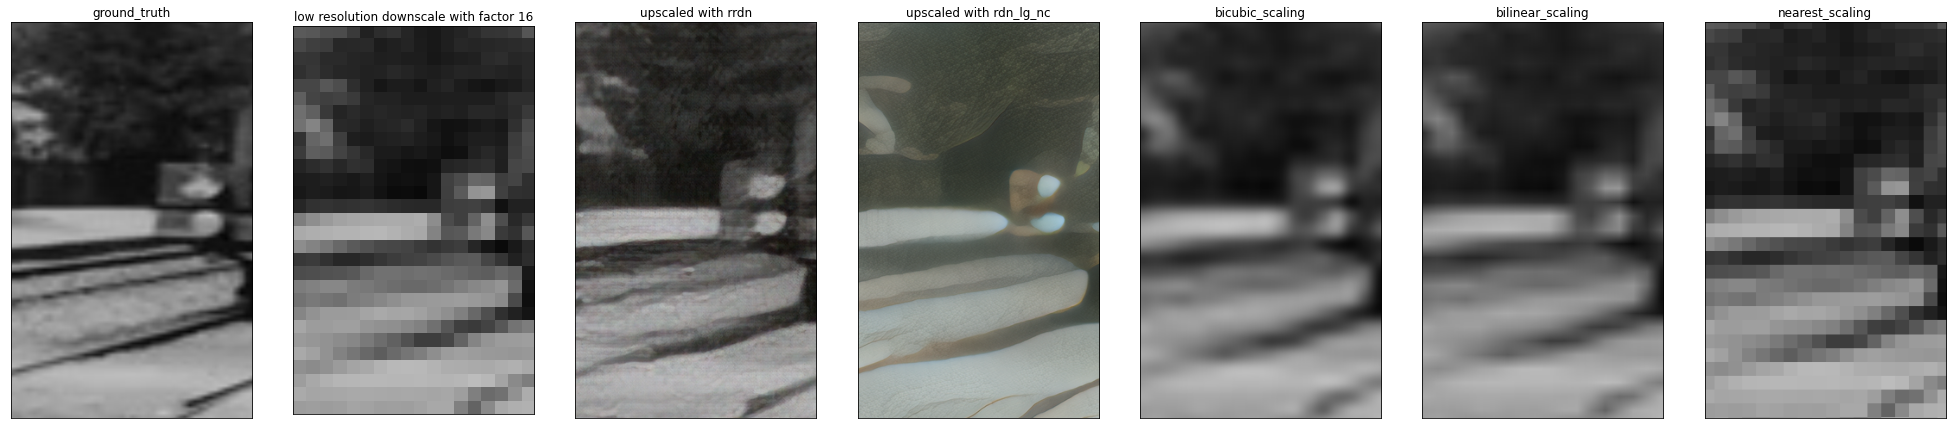

In [ ]:
scale_factor = 16

print(f"Proceeding image/frame with scale factor {scale_factor}")
image = wrapped_frames[0]

plot_and_save_upscaling_results(image, [scale_factor])

Let's procceed one more frame.. we will take second frame.

But now with a lower scale factor -> 8.

Proceeding image/frame with scale factor 8


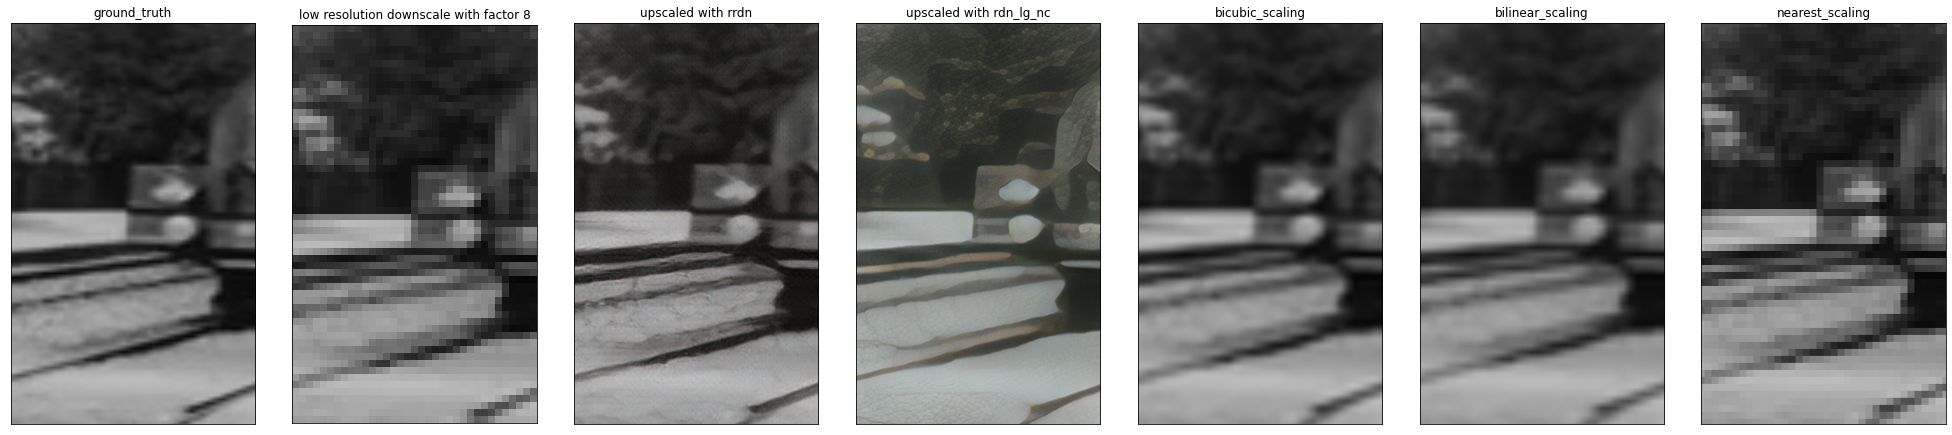

In [ ]:
scale_factor = 8

print(f"Proceeding image/frame with scale factor {scale_factor}")
image_second = wrapped_frames[1]

plot_and_save_upscaling_results(image_second, [scale_factor], save_output=False)

And last try with next frame.. 

Try to decrease scale factor to 4.

Proceeding image/frame with scale factor 4


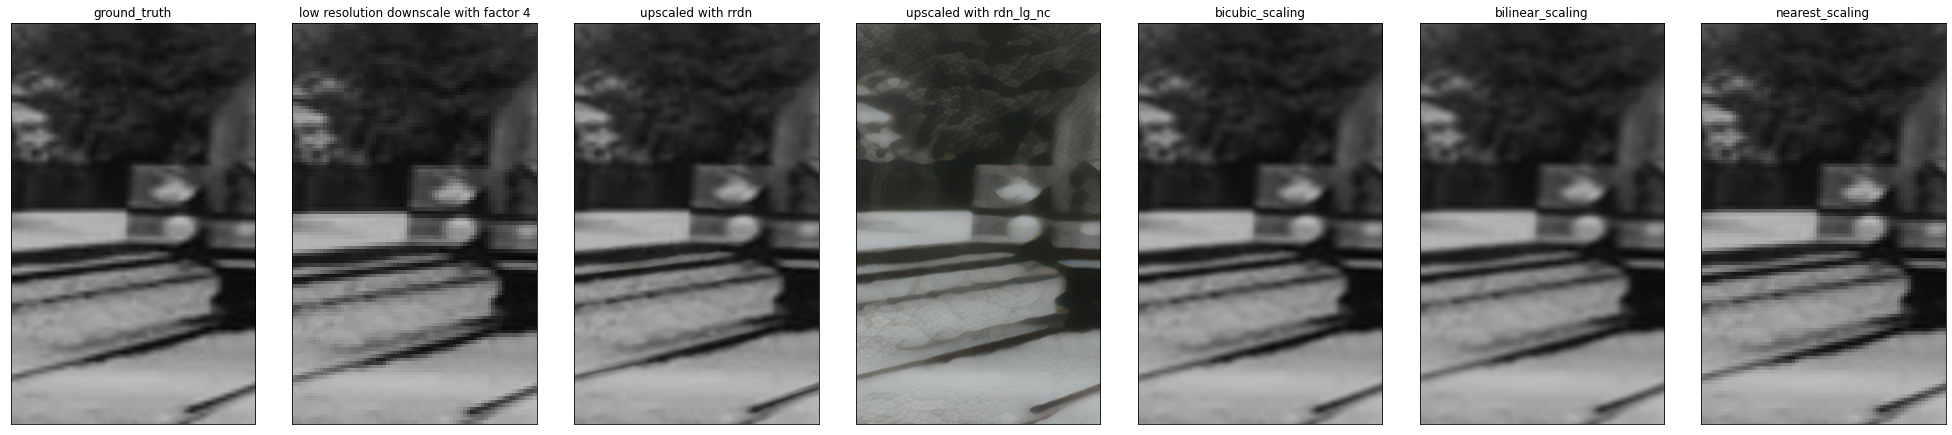

In [ ]:
scale_factor = 4

print(f"Proceeding image/frame with scale factor {scale_factor}")
image_third = wrapped_frames[2]

plot_and_save_upscaling_results(image_second, [scale_factor], save_output=False)

And last thing:

**RRDN** upscaling show itself as the best one.

So now let's display images for the last comparison.

We will compare:
1) downscaled with factor 16 image VS ground truth

2) downscaled with factor 16 image VS **RRDN** upscale

3) downscaled with factor 16 image VS **large RDN, noise cancelling** upscale

4) ground truth VS **large RDN, noise cancelling** upscale

5) ground truth VS **RRDN** upscale

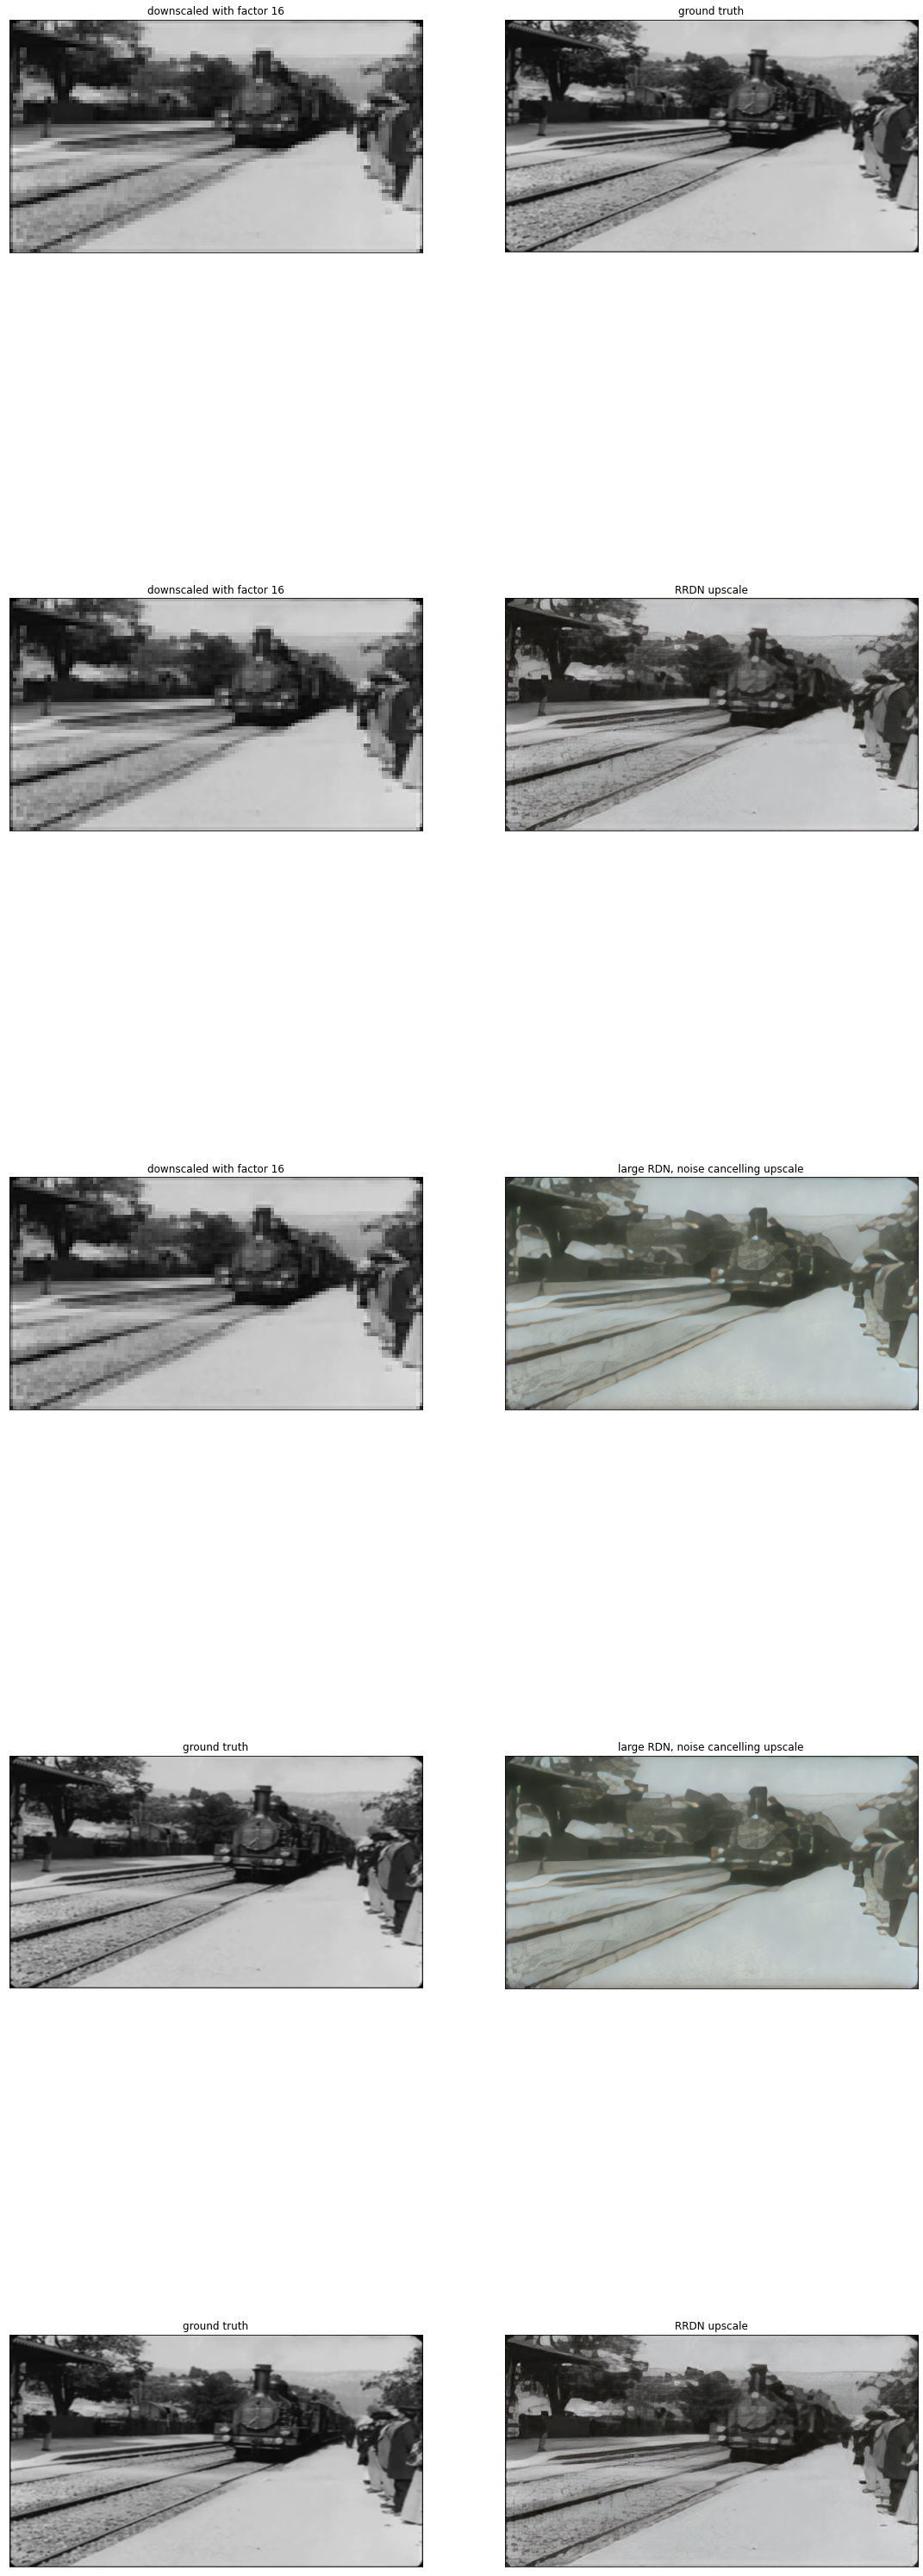

In [ ]:
# constants scope
crop = [780, 250, 1060, 710]

fig = plt.Figure()
DPI = fig.get_dpi()
x_size_in_inches = 680/float(DPI)
y_size_in_inches = 860/float(DPI)

nrows = 5
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        subplot_kw={'xticks': [], 'yticks': []})

fig.set_size_inches(x_size_in_inches*ncols,y_size_in_inches*nrows)

plotter = image_plotter(axs)

# provide scaling
ground_truth = wrapped_frames[0]
downscaled = ground_truth.spawn_new_downscaled_image(16)
upscaled_rrdn = downscaled.upscale_rrdn(model.RRDN, crop, (1920,1080))
upscaled_rdn_lg_nc = downscaled.upscale_rdn_lg_nc(model.RDN_LG_NC, crop, (1920,1080))

# 1) downscaled with factor 16 image VS ground truth
plotter(downscaled.image, "downscaled with factor 16")
plotter(ground_truth.image, "ground truth")

# 2) downscaled with factor 16 image VS RRDN upscale
plotter(downscaled.image, "downscaled with factor 16")
plotter(upscaled_rrdn.image, "RRDN upscale")

# 3) downscaled with factor 16 image VS large RDN, noise cancelling upscale
plotter(downscaled.image, "downscaled with factor 16")
plotter(upscaled_rdn_lg_nc.image, "large RDN, noise cancelling upscale")

# 4) ground truth VS large RDN, noise cancelling upscale
plotter(ground_truth.image, "ground truth")
plotter(upscaled_rdn_lg_nc.image, "large RDN, noise cancelling upscale")

# 5) ground truth VS RRDN upscale
plotter(ground_truth.image, "ground truth")
plotter(upscaled_rrdn.image, "RRDN upscale")


#### Summary:

The experiment carried out showed us the already obvious thing that the RRDN neural network showed itself the best.

And now finally, we can combine frames into a complete video.

For this purporces we will use predefined **frames_to_video_convertor.py**

In [ ]:
! python3 drive/MyDrive/MVI/frames_to_video_convertor.py --help

Usage: frames_to_video_convertor.py 
           [OPTIONS]

  Union frames from input directory to a single
  video

Options:
  -i, --input_path PATH   Path to to directory
                          with input frames.
                          [required]

  -o, --output_path PATH  Path to directory where
                          result video will be
                          saved.

  --help                  Show this message and
                          exit.


Despite the fact that we only made changes to the first frame with different techniques, we will show how, if necessary, you can combine all frames into one video.

Save output to : **./drive/MyDrive/MVI/data/videos_from_frames/** directory

In [ ]:
! python3 drive/MyDrive/MVI/frames_to_video_convertor.py -i drive/MyDrive/MVI/data/midified_frames/ -o drive/MyDrive/MVI/data/videos_from_frames/video_from_frames.mp4

Start reading directory with frames..
Start writing output video to path drive/MyDrive/MVI/data/videos_from_frames/video_from_frames.mp4
Done.


In [ ]:
! ls -l drive/MyDrive/MVI/data/videos_from_frames/

total 324
-rw------- 1 root root 331635 Dec 31 21:40 video_from_frames.mp4


Ok, it's here.

We successfully saved union of all frames to a single video.